In [70]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import copy
import os
import time

cudnn.benchmark = True

In [71]:
# Constants
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SEED = 490

In [72]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [74]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [75]:
# Create datasets
image_dataset = datasets.ImageFolder(data_dir, transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

In [76]:
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 75000
    Root location: /kaggle/input/rice-image-dataset/Rice_Image_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [77]:
val_length = int(len(image_dataset) * VAL_SIZE)
test_length = int(len(image_dataset) * TEST_SIZE)
train_length = len(image_dataset) - (val_length + test_length)
train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_length, val_length, test_length])

In [78]:
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val', 'test'] }

In [79]:
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=x!='test', num_workers=2)
              for x in ['train', 'val', 'test'] }

In [80]:
class_names = image_datasets['train'].dataset.classes
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [81]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

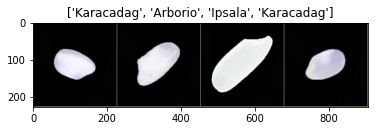

In [82]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs[:6])

# Display the images
imshow(out, title=[class_names[x] for x in classes[:]])

In [83]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - epoch_start
        print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [84]:
def get_test_accuracy(model):
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels.data)
    
    accuracy = correct.double() / dataset_sizes['test']
    
    print(f'Test accuracy: {accuracy:4f}')
    
    return accuracy

In [85]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# SqueezeNet with SGD

In [86]:
squeezenet1 = torchvision.models.squeezenet1_1(pretrained=True)
for param in squeezenet1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final convolution (1) of SqueezeNet has 512 input features
squeezenet1.classifier._modules['1'] = nn.Conv2d(512, 555 ,kernel_size=1)

squeezenet1 = squeezenet1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.SGD(squeezenet1.classifier._modules['1'].parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [87]:
# Training with optim.SGD
squeezenet1, s1_train_loss, s1_val_loss, s1_train_acc, s1_val_acc = train_model(
    squeezenet1, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2197 Acc: 0.9546
val Loss: 0.3335 Acc: 0.9604
Epoch time: 4m 9s

Epoch 1/19
----------
train Loss: 0.1254 Acc: 0.9707
val Loss: 0.3052 Acc: 0.9684
Epoch time: 4m 7s

Epoch 2/19
----------
train Loss: 0.1076 Acc: 0.9740
val Loss: 0.3329 Acc: 0.9581
Epoch time: 4m 7s

Epoch 3/19
----------
train Loss: 0.1022 Acc: 0.9759
val Loss: 0.2589 Acc: 0.9792
Epoch time: 4m 9s

Epoch 4/19
----------
train Loss: 0.0967 Acc: 0.9761
val Loss: 0.1522 Acc: 0.9792
Epoch time: 4m 12s

Epoch 5/19
----------
train Loss: 0.0889 Acc: 0.9785
val Loss: 0.2682 Acc: 0.9540
Epoch time: 4m 11s

Epoch 6/19
----------
train Loss: 0.0867 Acc: 0.9785
val Loss: 0.1707 Acc: 0.9806
Epoch time: 4m 11s

Epoch 7/19
----------
train Loss: 0.0624 Acc: 0.9842
val Loss: 0.0879 Acc: 0.9873
Epoch time: 4m 9s

Epoch 8/19
----------
train Loss: 0.0590 Acc: 0.9849
val Loss: 0.0974 Acc: 0.9864
Epoch time: 4m 10s

Epoch 9/19
----------
train Loss: 0.0552 Acc: 0.9860
val Loss: 0.0840 Acc: 0.9871
Epoch

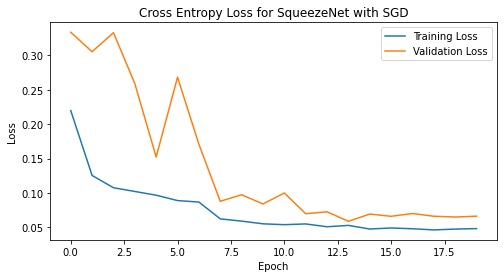

In [88]:
plt.figure(figsize=(8, 4))
plt.plot(s1_train_loss, label='Training Loss')
plt.plot(s1_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for SqueezeNet with SGD')
plt.savefig('SqueezeNet SGD Loss.png')
plt.show()

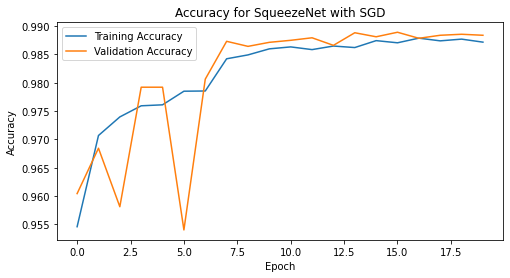

In [89]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in s1_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in s1_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for SqueezeNet with SGD')
plt.savefig('SqueezeNet SGD Accuracy.png')
plt.show()

In [90]:
torch.save(squeezenet1.state_dict(), 'squeezenet1.pth')

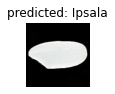

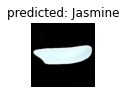

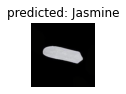

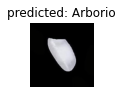

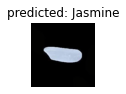

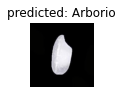

In [91]:
visualize_model(squeezenet1)

plt.show()

In [92]:
s1_test_accuracy = get_test_accuracy(squeezenet1)

Test accuracy: 0.990311


# SqueezeNet with Adadelta

In [93]:
squeezenet2 = torchvision.models.squeezenet1_1(pretrained=True)
for param in squeezenet2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final convolution (1) of SqueezeNet has 512 input features
squeezenet2.classifier._modules['1'] = nn.Conv2d(512, 555 ,kernel_size=1)

squeezenet2 = squeezenet2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.SGD(squeezenet2.classifier._modules['1'].parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [94]:
# Training with optim.SGD
squeezenet2, s2_train_loss, s2_val_loss, s2_train_acc, s2_val_acc = train_model(
    squeezenet2, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2338 Acc: 0.9534
val Loss: 0.4458 Acc: 0.9629
Epoch time: 4m 13s

Epoch 1/19
----------
train Loss: 0.1295 Acc: 0.9714
val Loss: 0.2203 Acc: 0.9777
Epoch time: 4m 7s

Epoch 2/19
----------
train Loss: 0.1087 Acc: 0.9746
val Loss: 0.3942 Acc: 0.9676
Epoch time: 4m 7s

Epoch 3/19
----------
train Loss: 0.0970 Acc: 0.9757
val Loss: 0.3151 Acc: 0.9629
Epoch time: 4m 10s

Epoch 4/19
----------
train Loss: 0.0963 Acc: 0.9774
val Loss: 0.3137 Acc: 0.9620
Epoch time: 4m 9s

Epoch 5/19
----------
train Loss: 0.0901 Acc: 0.9782
val Loss: 0.1194 Acc: 0.9850
Epoch time: 4m 8s

Epoch 6/19
----------
train Loss: 0.0881 Acc: 0.9785
val Loss: 0.1305 Acc: 0.9850
Epoch time: 4m 7s

Epoch 7/19
----------
train Loss: 0.0614 Acc: 0.9843
val Loss: 0.1634 Acc: 0.9836
Epoch time: 4m 7s

Epoch 8/19
----------
train Loss: 0.0538 Acc: 0.9854
val Loss: 0.1317 Acc: 0.9852
Epoch time: 4m 7s

Epoch 9/19
----------
train Loss: 0.0555 Acc: 0.9862
val Loss: 0.1235 Acc: 0.9860
Epoch t

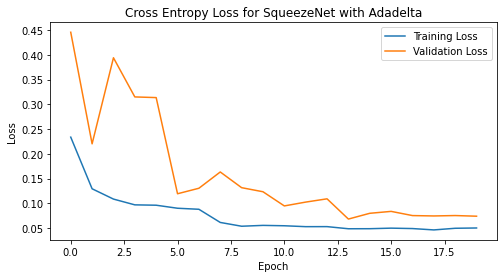

In [95]:
plt.figure(figsize=(8, 4))
plt.plot(s2_train_loss, label='Training Loss')
plt.plot(s2_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for SqueezeNet with Adadelta')
plt.savefig('SqueezeNet Adadelta Loss.png')
plt.show()

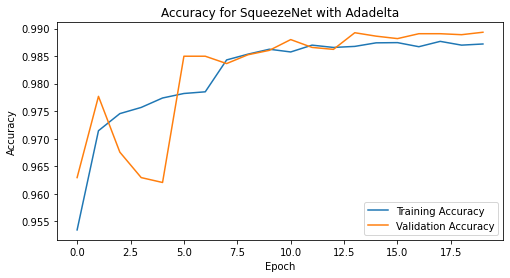

In [96]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in s2_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in s2_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for SqueezeNet with Adadelta')
plt.savefig('SqueezeNet Adadelta Accuracy.png')
plt.show()

In [97]:
torch.save(squeezenet2.state_dict(), 'squeezenet2.pth')

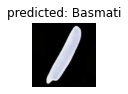

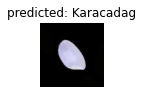

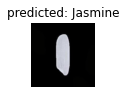

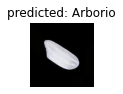

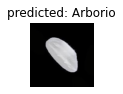

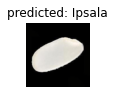

In [98]:
visualize_model(squeezenet2)

plt.show()

In [99]:
s2_test_accuracy = get_test_accuracy(squeezenet2)

Test accuracy: 0.989511


# SqueezeNet with RMSprop

In [100]:
squeezenet3 = torchvision.models.squeezenet1_1(pretrained=True)
for param in squeezenet3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Final convolution (1) of SqueezeNet has 512 input features
squeezenet3.classifier._modules['1'] = nn.Conv2d(512, 555 ,kernel_size=1)

squeezenet3 = squeezenet3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.SGD(squeezenet3.classifier._modules['1'].parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [101]:
# Training with optim.SGD
squeezenet3, s3_train_loss, s3_val_loss, s3_train_acc, s3_val_acc = train_model(
    squeezenet3, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1996 Acc: 0.9549
val Loss: 0.2366 Acc: 0.9765
Epoch time: 4m 7s

Epoch 1/19
----------
train Loss: 0.1245 Acc: 0.9713
val Loss: 0.2215 Acc: 0.9696
Epoch time: 4m 7s

Epoch 2/19
----------
train Loss: 0.1071 Acc: 0.9738
val Loss: 0.3501 Acc: 0.9631
Epoch time: 4m 6s

Epoch 3/19
----------
train Loss: 0.1020 Acc: 0.9760
val Loss: 0.2237 Acc: 0.9758
Epoch time: 4m 6s

Epoch 4/19
----------
train Loss: 0.0906 Acc: 0.9772
val Loss: 0.2421 Acc: 0.9736
Epoch time: 4m 6s

Epoch 5/19
----------
train Loss: 0.0882 Acc: 0.9783
val Loss: 0.1677 Acc: 0.9765
Epoch time: 4m 5s

Epoch 6/19
----------
train Loss: 0.0897 Acc: 0.9777
val Loss: 0.1988 Acc: 0.9858
Epoch time: 4m 6s

Epoch 7/19
----------
train Loss: 0.0610 Acc: 0.9845
val Loss: 0.1474 Acc: 0.9849
Epoch time: 4m 6s

Epoch 8/19
----------
train Loss: 0.0552 Acc: 0.9854
val Loss: 0.0902 Acc: 0.9874
Epoch time: 4m 6s

Epoch 9/19
----------
train Loss: 0.0525 Acc: 0.9859
val Loss: 0.0991 Acc: 0.9879
Epoch tim

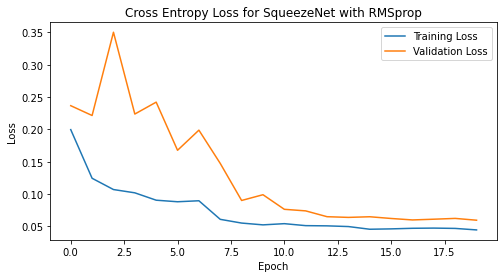

In [102]:
plt.figure(figsize=(8, 4))
plt.plot(s3_train_loss, label='Training Loss')
plt.plot(s3_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Entropy Loss for SqueezeNet with RMSprop')
plt.savefig('SqueezeNet RMSprop Loss.png')
plt.show()

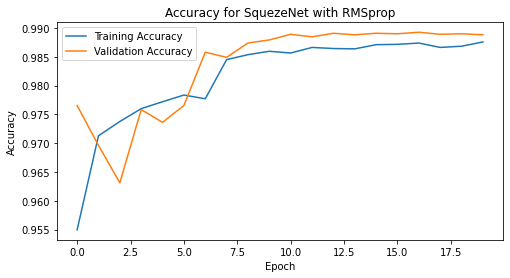

In [103]:
plt.figure(figsize=(8, 4))
plt.plot([acc.cpu() for acc in s3_train_acc], label='Training Accuracy')
plt.plot([acc.cpu() for acc in s3_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for SquezeNet with RMSprop')
plt.savefig('SquezeNet RMSprop Accuracy.png')
plt.show()

In [104]:
torch.save(squeezenet1.state_dict(), 'squeezenet3.pth')

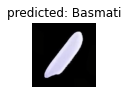

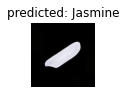

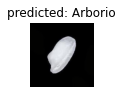

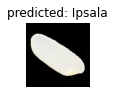

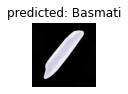

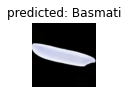

In [105]:
visualize_model(squeezenet3)

plt.show()

In [106]:
s3_test_accuracy = get_test_accuracy(squeezenet3)

Test accuracy: 0.991111
